# Assignment 1: DepMap Data Analysis

## Integrating Gene Expression and Dependency to Discover Therapeutic Targets

**Due Date:** [To be announced]

**Total Points:** 15 points (Part 1 only)

---

## Project Overview

In this project, you will analyze preprocessed data from the Cancer Dependency Map (DepMap) to identify potential therapeutic targets by integrating two complementary data types: gene expression levels and gene dependencies. By examining relationships within and across these datasets, you'll uncover functional connections that could inform drug development strategies.

**Real-World Impact:** This integrated approach mirrors how pharmaceutical companies identify drug targets - finding genes that are both essential for cancer survival (dependency) and differentially expressed (druggable).

---

## Dataset Description

**Data Access:** All preprocessed data available via Zenodo [link to be provided]

You will work with two main data files:

### 1. CRISPR Dependency Scores (`matched_crispr.csv`)
- **Rows:** ~1,000 cancer cell lines
- **Columns:** 9 metadata columns + ~17,000 gene columns
- **Values:** CERES dependency scores (more negative = stronger dependency)
- Pre-filtered for quality and consistency

### 2. Gene Expression Data (`matched_expression.csv`)
- **Rows:** Same ~1,000 cancer cell lines (matched to CRISPR data)
- **Columns:** 9 metadata columns + same ~17,000 gene columns
- **Values:** log2(TPM+1) normalized expression values
- Batch-corrected and standardized

### Metadata Columns (first 9 columns in both files):
- `model_id` - Unique cell line identifier
- `cell_line_name` - Cell line name
- `stripped_cell_line_name` - Simplified name
- `oncotree_lineage` - Cancer type (e.g., "Breast", "Myeloid")
- `oncotree_primary_disease` - Specific disease
- `oncotree_subtype` - Disease subtype
- `oncotree_code` - Standardized cancer code
- `ccle_name` - CCLE database name
- `depmap_model_type` - Model type

---

## 📊 Understanding the Data Values

### CRISPR Dependency Scores:
- **Negative values** (e.g., -0.8): The gene is **ESSENTIAL** - cells die without it
- **Near zero** (e.g., -0.1 to 0.1): The gene is **NOT essential**
- **Positive values** (e.g., +0.3): Cells grow **BETTER** without this gene

### Gene Expression (log2 TPM+1):
- **0**: Gene is not expressed at all
- **2-4**: Low expression
- **5-8**: Medium expression
- **>8**: High expression

---

## What You'll Learn in Part 1

In this first part, you'll get comfortable with the data by:
- Understanding what CRISPR dependency scores mean
- Understanding what gene expression values represent
- Loading large datasets into pandas DataFrames
- Separating metadata from gene data
- Calculating and comparing summary statistics
- Creating multi-panel scientific figures
- Investigating relationships between expression and dependency

---

## Setup and Imports

Run this cell to import all necessary libraries.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

print("Libraries loaded successfully!")

Libraries loaded successfully!


---

# Part 1: Data Loading and Initial Analysis (15 points)

## Step 1.1: Load the Data (3 points)

**Task:** Write a function `load_depmap_data()` that loads both CSV files and organizes the data.

**Requirements:**
- Takes two file paths as input (crispr_path, expression_path)
- Loads both CSV files using `pd.read_csv()`
- Separates the 9 metadata columns from gene columns
- Returns three objects:
  - `crispr_data` - DataFrame with only gene columns (no metadata)
  - `expression_data` - DataFrame with only gene columns (no metadata)
  - `metadata` - DataFrame with only the 9 metadata columns
- Prints a summary: "✓ Loaded X cell lines and Y genes"

**Hint:** Create a list of metadata column names, then select gene columns with:
```python
gene_cols = [col for col in df.columns if col not in metadata_cols]
```

In [3]:
def load_depmap_data(crispr_path, expression_path):
    """
    Load DepMap CRISPR dependency and gene expression data.
    
    Parameters:
    -----------
    crispr_path : str
        Path to CRISPR dependency scores CSV file
    expression_path : str
        Path to gene expression CSV file
        
    Returns:
    --------
    crispr_data : pandas.DataFrame
        CRISPR dependency scores (only gene columns)
    expression_data : pandas.DataFrame
        Gene expression values (only gene columns)
    metadata : pandas.DataFrame
        Cell line metadata (9 columns)
    """
    # Load data
    crispr_df = pd.read_csv(crispr_path)
    expression_df = pd.read_csv(expression_path)

    # Define metadata columns
    metadata_cols = [
        "model_id",
        "cell_line_name",
        "stripped_cell_line_name",
        "oncotree_lineage",
        "oncotree_primary_disease",
        "oncotree_subtype",
        "oncotree_code",
        "ccle_name",
        "depmap_model_type",
    ]

    # Extract metadata (same for both datasets)
    metadata = crispr_df[metadata_cols].copy()

    # Get gene columns (everything after metadata)
    gene_cols = [col for col in crispr_df.columns if col not in metadata_cols]

    # Create gene-only dataframes
    crispr_genes = crispr_df[gene_cols]
    expression_genes = expression_df[gene_cols]

    print("✓ Data loaded successfully")
    print(f"  Cell lines: {len(crispr_genes)}")
    print(f"  Genes: {len(gene_cols)}")
    print(f"  Cancer types: {metadata['oncotree_lineage'].nunique()}")

    return crispr_genes, expression_genes, metadata

# Load the data (update these paths to match your data location)
crispr_data, expression_data, metadata = load_depmap_data(
    '/Users/hh65/depmap_data/matched_crispr.csv',
    '/Users/hh65/depmap_data/matched_expression.csv'
)

✓ Data loaded successfully
  Cell lines: 1091
  Genes: 17121
  Cancer types: 29


---

## Step 1.2: Verify Data Alignment (2 points)

**Task:** Gneretae a function that veridies that both datasets are properly aligned.

**Verification checks:**
- Both datasets have the same number of rows (cell lines)
- Gene column names match exactly between datasets
- No duplicate gene names
- Print confirmation messages for each check

**Expected output:**
```
if the shape of the two data setis the same:
Quality control passed
```
if it is not the same:

Warning!! Data are not aligned

**Hint:** Use df.shape


In [6]:
# YOUR CODE HERE
def quality_control(df1, df2):
    """checks if the shape of df1 is the the same as df2"""
    if df1.shape == df2.shape:
        print("Quality control passed")
    else:
        print("Warning!! Data are not aligned")

# Run quality control
quality_control(crispr_data, expression_data)

Quality control passed


---

## Step 1.3: Explore Data Structure (2 points)

**Task1:** Generate a function to display information about the numeric datasets.

**Required outputs:**
- Shape of the DataFrame (rows × columns)
- Number missing values (hint: use the .isna() method
- Show first 5 gene names

**Task2:** Analyse the cancer types in the metadata set

**Required outputs:**
- Number of differnet cancertypes
- Number of cell lines for each cancer type


In [ ]:
# task 1 

def data_check(df, df_name):
    print(f"{df_name} has the shape {df.shape}")
    print(f"{df_name} has {df.isna().sum().sum()} missing values")
    print(f" The first 3 genes in the df are {df.columns[0:5]}")
   
data_check(crispr_data, "crispr_data")
data_check(expression_data, "expression_data")




crispr_data has the shape (1091, 17121)
crispr_data has 0 missing values
 The first 3 genes in the df are Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2'], dtype='object')
expression_data has the shape (1091, 17121)
expression_data has 0 missing values
 The first 3 genes in the df are Index(['A1BG', 'A1CF', 'A2M', 'A2ML1', 'A3GALT2'], dtype='object')


In [19]:
#task 2
print(f"The data have {len(metadata.oncotree_lineage.unique())} different cancertypes")
print(metadata.groupby(["oncotree_lineage"])["model_id"].count())

The data have 29 different cancertypes
oncotree_lineage
Adrenal Gland                  1
Ampulla of Vater               5
Biliary Tract                 34
Bladder/Urinary Tract         34
Bone                          34
Bowel                         58
Breast                        50
CNS/Brain                     81
Cervix                        18
Esophagus/Stomach             62
Eye                           15
Fibroblast                     1
Head and Neck                 59
Kidney                        32
Liver                         24
Lung                         121
Lymphoid                      90
Myeloid                       39
Ovary/Fallopian Tube          56
Pancreas                      45
Peripheral Nervous System     37
Pleura                        21
Prostate                      10
Skin                          72
Soft Tissue                   43
Testis                         2
Thyroid                       11
Uterus                        34
Vulva/Vagina        

---

## Step 1.4: Summary Statistics (3 points)

**Task:** Display summary statistics for both datasets using the `.describe()` function.

**Instructions:**
- Use `.describe()` on both `crispr_data` and `expression_data`
- This will show count, mean, std, min, 25%, 50%, 75%, and max values

**Hint:** The `.describe()` function automatically calculates common statistics across all columns.

In [ ]:
print("CRISPR Dependency Statistics:")
print(crispr_data.describe())
print()

print("Gene Expression Statistics:")
print(expression_data.describe())


---

## Step 1.5: Distribution Plots (3 points)

**Task:** Create side-by-side histograms showing the distribution of values in each dataset.

**Requirements:**
- Two subplots in one figure: `fig, axes = plt.subplots(1, 2, figsize=(14, 5))`
- Left panel: Histogram of all CRISPR dependency scores
  - Add vertical line at 0 (neutral dependency)
  - Add vertical line at -0.5 (strong dependency threshold)
- Right panel: Histogram of all gene expression values
  - Add vertical line at median expression
- Clear axis labels and titles
- Legend for reference lines

**Questions to answer:**
- What shape is the CRISPR distribution?
- Where are most genes in terms of dependency?
- What shape is the expression distribution?
- Are most genes highly or lowly expressed?

**Hint:** Flatten the data for histograms:
```python
axes[0].hist(crispr_data.values.flatten(), bins=100)
```

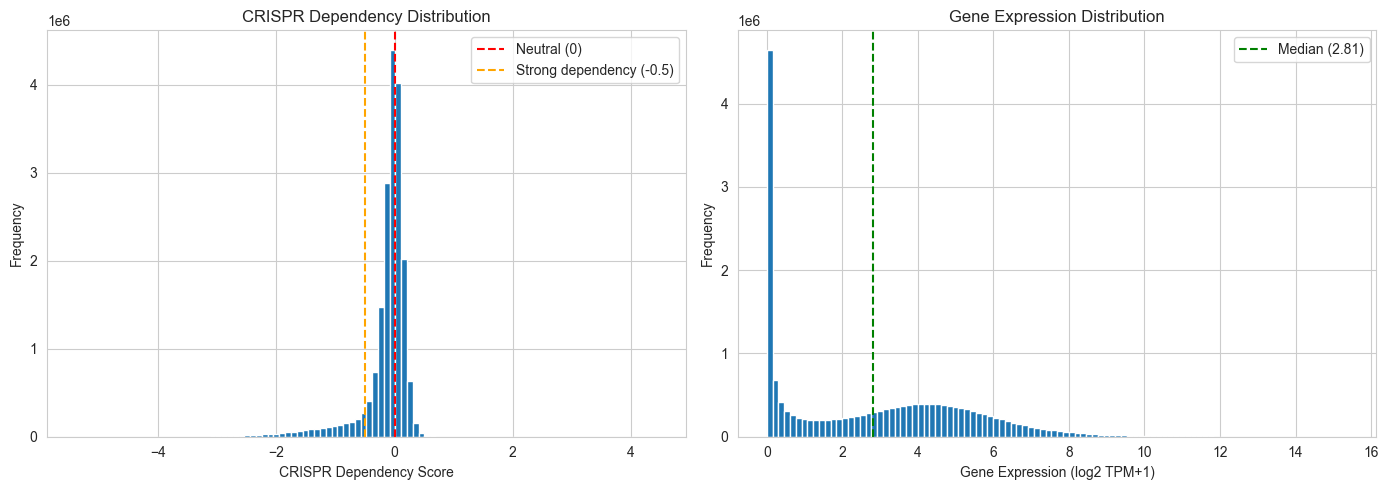

In [20]:
# Create side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: CRISPR dependency
axes[0].hist(crispr_data.values.flatten(), bins=100)
axes[0].axvline(0, color='red', linestyle='--', label='Neutral (0)')
axes[0].axvline(-0.5, color='orange', linestyle='--', label='Strong dependency (-0.5)')
axes[0].set_xlabel('CRISPR Dependency Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('CRISPR Dependency Distribution')
axes[0].legend()

# Right panel: Gene expression
median_expr = np.median(expression_data.values)
axes[1].hist(expression_data.values.flatten(), bins=100)
axes[1].axvline(median_expr, color='green', linestyle='--', label=f'Median ({median_expr:.2f})')
axes[1].set_xlabel('Gene Expression (log2 TPM+1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Gene Expression Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()


**Write your observations here:**

- CRISPR distribution shape:
- Where are most genes:
- Expression distribution shape:
- Expression level of most genes:

---

## Step 1.6: Expression vs Dependency Analysis (4 points)

**Task:** Investigate the fundamental question: **Are highly expressed genes more likely to be essential?**

**Steps:**
1. Calculate the mean expression for each gene (across all cell lines)
   - `mean_expression = expression_data.mean(axis=0)`
2. Calculate the mean dependency for each gene (across all cell lines)
   - `mean_dependency = crispr_data.mean(axis=0)`
3. Create a scatter plot with:
   - X-axis: Mean expression
   - Y-axis: Mean dependency
   - Each point represents one gene (~17,000 points)
   - Use `alpha=0.3` to see overlapping points
4. Calculate Pearson correlation using `stats.pearsonr()`
5. Add reference lines for context

**Questions to answer:**
- Is there a correlation between expression and dependency?
- What does a negative correlation mean biologically?
- What does a positive correlation mean?
- Are highly expressed genes more or less essential?

**Hint:** The scatter plot should have ~17,000 points (one per gene).

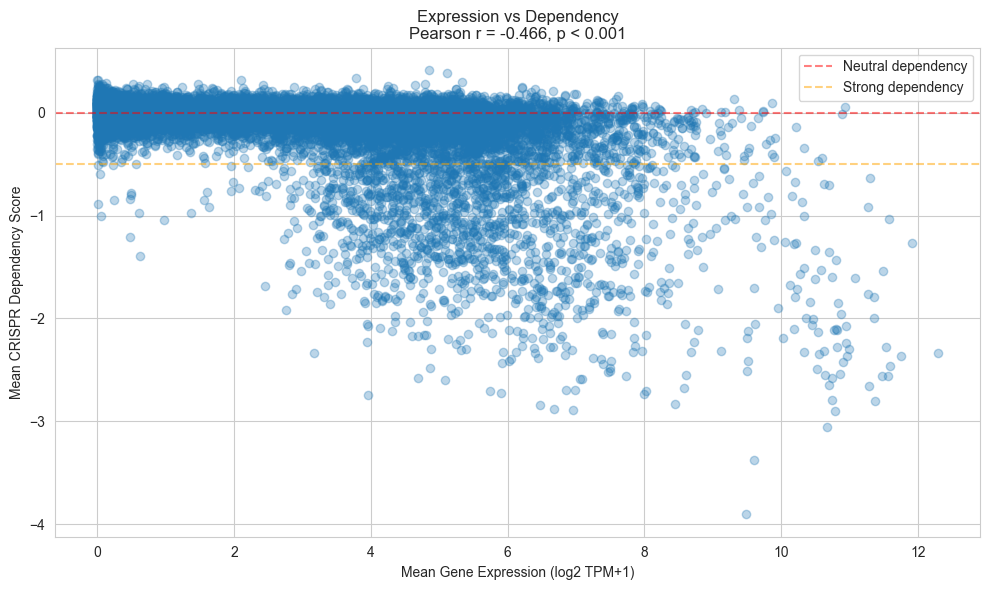

Correlation coefficient: r = -0.4662
P-value: 0.00e+00
Number of genes analyzed: 17121


In [22]:
# Calculate mean expression and dependency for each gene
mean_expression = expression_data.mean(axis=0)
mean_dependency = crispr_data.mean(axis=0)

# Calculate Pearson correlation
correlation, p_value = stats.pearsonr(mean_expression, mean_dependency)

# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(mean_expression, mean_dependency, alpha=0.3)
ax.set_xlabel('Mean Gene Expression (log2 TPM+1)')
ax.set_ylabel('Mean CRISPR Dependency Score')
ax.set_title(f'Expression vs Dependency\nPearson r = {correlation:.3f}, p < 0.001')

# Add reference lines
ax.axhline(0, color='red', linestyle='--', alpha=0.5, label='Neutral dependency')
ax.axhline(-0.5, color='orange', linestyle='--', alpha=0.5, label='Strong dependency')

ax.legend()
plt.tight_layout()
plt.show()

print(f"Correlation coefficient: r = {correlation:.4f}")
print(f"P-value: {p_value:.2e}")
print(f"Number of genes analyzed: {len(mean_expression)}")


**Write your interpretation here:**

- Correlation coefficient (r = ?):
- Is there a correlation?:
- What does negative correlation mean?:
- What does positive correlation mean?:
- Are highly expressed genes more/less essential?:

## Step 1.6 Filtering out genes with low expression

From our analysis it looks like the genes with very low expression are skewing the data. 
Lets try and filter those out and analyse the correlation again.

**task1** generate filtered data to rule out genes with mean expression < 0.5
**task2** analyse the dependency/expression correlation again


Original number of genes: 17121
Filtered number of genes: 13213
Genes removed: 3908



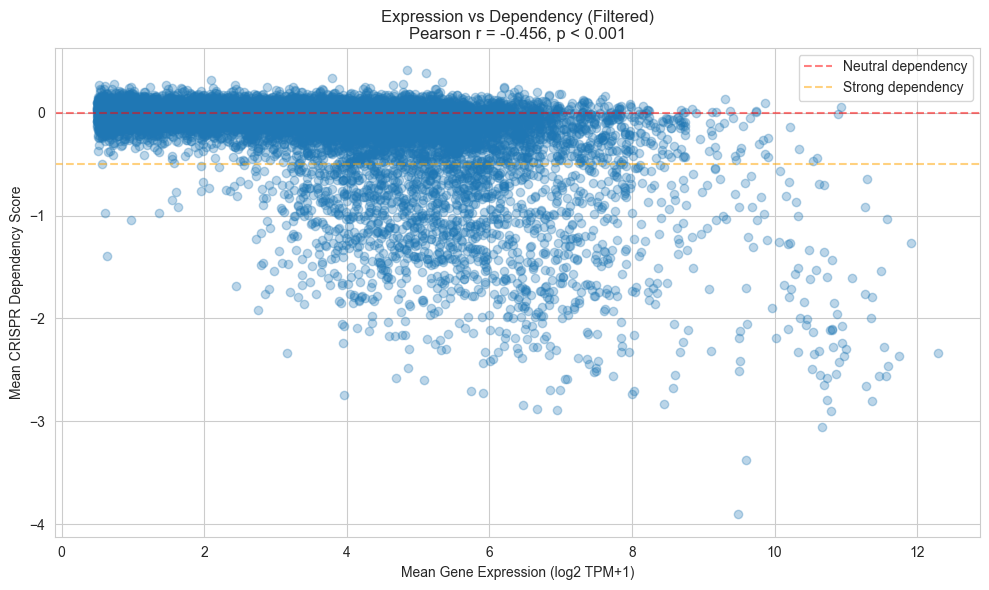

Filtered correlation coefficient: r = -0.4562
Original correlation coefficient: r = -0.4662
Change in correlation: 0.0100


In [23]:
# Task 1: Filter genes with mean expression >= 0.5
filter_mask = mean_expression >= 0.5
mean_expression_filtered = mean_expression[filter_mask]
mean_dependency_filtered = mean_dependency[filter_mask]

print(f"Original number of genes: {len(mean_expression)}")
print(f"Filtered number of genes: {len(mean_expression_filtered)}")
print(f"Genes removed: {len(mean_expression) - len(mean_expression_filtered)}")
print()

# Task 2: Analyze correlation with filtered data
correlation_filtered, p_value_filtered = stats.pearsonr(mean_expression_filtered, mean_dependency_filtered)

# Create scatter plot with filtered data
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(mean_expression_filtered, mean_dependency_filtered, alpha=0.3)
ax.set_xlabel('Mean Gene Expression (log2 TPM+1)')
ax.set_ylabel('Mean CRISPR Dependency Score')
ax.set_title(f'Expression vs Dependency (Filtered)\nPearson r = {correlation_filtered:.3f}, p < 0.001')

# Add reference lines
ax.axhline(0, color='red', linestyle='--', alpha=0.5, label='Neutral dependency')
ax.axhline(-0.5, color='orange', linestyle='--', alpha=0.5, label='Strong dependency')

ax.legend()
plt.tight_layout()
plt.show()

print(f"Filtered correlation coefficient: r = {correlation_filtered:.4f}")
print(f"Original correlation coefficient: r = {correlation:.4f}")
print(f"Change in correlation: {correlation_filtered - correlation:.4f}")


---

## 💡 Helpful Hints for Part 1

### Working with large DataFrames:
- Use `.head()` to preview data without printing everything
- Use `.shape` to check dimensions
- Use `.columns` to see all column names

### Calculating statistics:
- `.mean(axis=0)` - mean of each column (across rows)
- `.mean(axis=1)` - mean of each row (across columns)
- `.values.flatten()` - convert entire DataFrame to 1D array

### Plotting tips:
- `alpha=0.3` makes overlapping points visible
- `figsize=(10, 6)` controls figure size
- Always label axes with units!

### Common issues:
- If code is slow, you're working with 17 million data points - that's normal!
- Make sure to separate metadata before calculations
- Use `.isna().sum().sum()` to count ALL missing values in DataFrame

---

## ✅ Expected Outputs for Part 1

After completing Part 1, you should have:
- [ ] A working `load_depmap_data()` function
- [ ] Printed confirmation: "✓ Loaded X cell lines and Y genes"
- [ ] Data alignment verification messages
- [ ] Exploration output showing shapes and cancer type counts
- [ ] A summary statistics table (6 rows × 2 columns)
- [ ] Two side-by-side histograms showing distributions
- [ ] One scatter plot with ~17,000 points
- [ ] A correlation coefficient (r = ?) and interpretation

**Success criteria:**
- All code runs without errors
- All plots have clear labels and titles
- You can explain what the correlation means biologically

---

## Submission Instructions

1. **Save your notebook** with all code cells executed
2. **Clear all outputs** and **run all cells** from top to bottom to ensure everything works
3. **Export to HTML**: File → Export Notebook As → HTML
4. **Submit both**:
   - The `.ipynb` file
   - The `.html` file

**Deadline:** [To be announced]

---

**Good luck! 🧬🔬**